
# Covid-19 Overview in Greece

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [New cases graph](#new_cases_graph)
* [New deaths graph](#new_deaths_graph)
* [Total cases graph](#total_cases_graph)
* [Total deaths graph](#total_deaths_graph)
* [Prediction of new deaths](#prediction_new_deaths)
* [Prediction of new cases](#prediction_new_cases)

# Introduction <a name="introduction"></a>



## Data <a name="data"></a>

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import scipy
import plotly
import folium
from folium import plugins
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from lime import lime_tabular
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas as pd
from datetime import datetime

In [398]:
#!wget -nv https://covid19.who.int/WHO-COVID-19-global-data.csv
#print('File downloaded!')
file_name=('cov.csv')
df_raw=pd.read_csv(file_name)
print('File copied to DataFrame!')
#os.remove("WHO-COVID-19-global-data.csv")
#print("File Removed!")

File copied to DataFrame!


In [399]:
predicted_new_cases_file_name = 'new_cases_' + str(datetime.now().strftime('%Y_%m_%d')) + '.csv'
predicted_new_deaths_file_name = 'new_deaths_' + str(datetime.now().strftime('%Y_%m_%d')) + '.csv'
predicted_new_intubated_file_name = 'new_intubated_' + str(datetime.now().strftime('%Y_%m_%d')) + '.csv'

In [400]:
df_raw.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,intubated
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0,NaN
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0,NaN
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0,NaN
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0,NaN
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0,NaN


#### Removing data from all the countries except Greece

In [401]:
df_raw=df_raw[df_raw['Country'].str.contains('Greece')]
df_raw.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,intubated
28269,2020-01-03,GR,Greece,EURO,0,0,0,0,NaN
28270,2020-01-04,GR,Greece,EURO,0,0,0,0,NaN
28271,2020-01-05,GR,Greece,EURO,0,0,0,0,NaN
28272,2020-01-06,GR,Greece,EURO,0,0,0,0,NaN
28273,2020-01-07,GR,Greece,EURO,0,0,0,0,NaN


#### Removing unnecessary data columns

In [402]:
df_raw.drop(columns=["Country_code", "WHO_region", "Country"], inplace=True)
df_raw.head()

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,intubated
28269,2020-01-03,0,0,0,0,NaN
28270,2020-01-04,0,0,0,0,NaN
28271,2020-01-05,0,0,0,0,NaN
28272,2020-01-06,0,0,0,0,NaN
28273,2020-01-07,0,0,0,0,NaN


#### Renaming columns

In [403]:
df_raw=df_raw.rename(columns={"Cumulative_cases": "Total_cases", "Cumulative_deaths": "Total_deaths"})
df_raw.head()

,Date_reported,New_cases,Total_cases,New_deaths,Total_deaths,intubated
28269,2020-01-03,0,0,0,0,NaN
28270,2020-01-04,0,0,0,0,NaN
28271,2020-01-05,0,0,0,0,NaN
28272,2020-01-06,0,0,0,0,NaN
28273,2020-01-07,0,0,0,0,NaN


#### Sorting the dataframe by Date

In [404]:
df_raw=df_raw.sort_values(by='Date_reported', ascending=False)
df_raw.head()

,Date_reported,New_cases,Total_cases,New_deaths,Total_deaths,intubated
28629,2020-12-28,342,135456,53,4606,469.0
28628,2020-12-27,262,135114,46,4553,473.0
28627,2020-12-26,617,134852,50,4507,470.0
28626,2020-12-25,873,134235,55,4442,476.0
28625,2020-12-24,934,133435,62,4384,495.0


#### Converting 'Date_reported' to datetime

In [405]:
df_raw.Date_reported = pd.to_datetime(df_raw.Date_reported).dt.date

In [406]:
df_raw.head(10)

,Date_reported,New_cases,Total_cases,New_deaths,Total_deaths,intubated
28629,2020-12-28,342,135456,53,4606,469.0
28628,2020-12-27,262,135114,46,4553,473.0
28627,2020-12-26,617,134852,50,4507,470.0
28626,2020-12-25,873,134235,55,4442,476.0
28625,2020-12-24,934,133435,62,4384,495.0
28624,2020-12-23,853,132501,83,4322,491.0
28623,2020-12-22,526,131648,85,4239,505.0
28622,2020-12-21,588,131122,70,4154,515.0
28621,2020-12-20,901,130534,58,4084,534.0
28620,2020-12-19,916,129633,96,4026,527.0


#### Correcting the deviation of the day

In [407]:
df_copy = df_raw.copy()
df_copy['Date_reported']=df_copy['Date_reported'].shift(-1)
df_copy.head()

,Date_reported,New_cases,Total_cases,New_deaths,Total_deaths,intubated
28629,2020-12-27,342,135456,53,4606,469.0
28628,2020-12-26,262,135114,46,4553,473.0
28627,2020-12-25,617,134852,50,4507,470.0
28626,2020-12-24,873,134235,55,4442,476.0
28625,2020-12-23,934,133435,62,4384,495.0


In [408]:
df_copy = df_copy.iloc[:-324]

In [409]:
df_copy=df_copy.sort_values(by='Total_cases', ascending=True)
df_copy.intubated = df_copy.intubated.astype(int)

In [410]:
df_copy.style.background_gradient(cmap='Reds')

,Date_reported,New_cases,Total_cases,New_deaths,Total_deaths,intubated
28593,2020-11-21,2309,90121,108,1527,522
28594,2020-11-22,1498,91619,103,1630,540
28595,2020-11-23,1387,93006,84,1714,549
28596,2020-11-24,2131,95137,101,1815,562
28597,2020-11-25,2151,97288,87,1902,597
28598,2020-11-26,2018,99306,99,2001,608
28599,2020-11-27,1981,101287,101,2102,607
28600,2020-11-28,1747,103034,121,2223,606
28601,2020-11-29,1193,104227,98,2321,603
28602,2020-11-30,1044,105271,85,2406,600


# New cases graph<a name="new_cases_graph"></a>

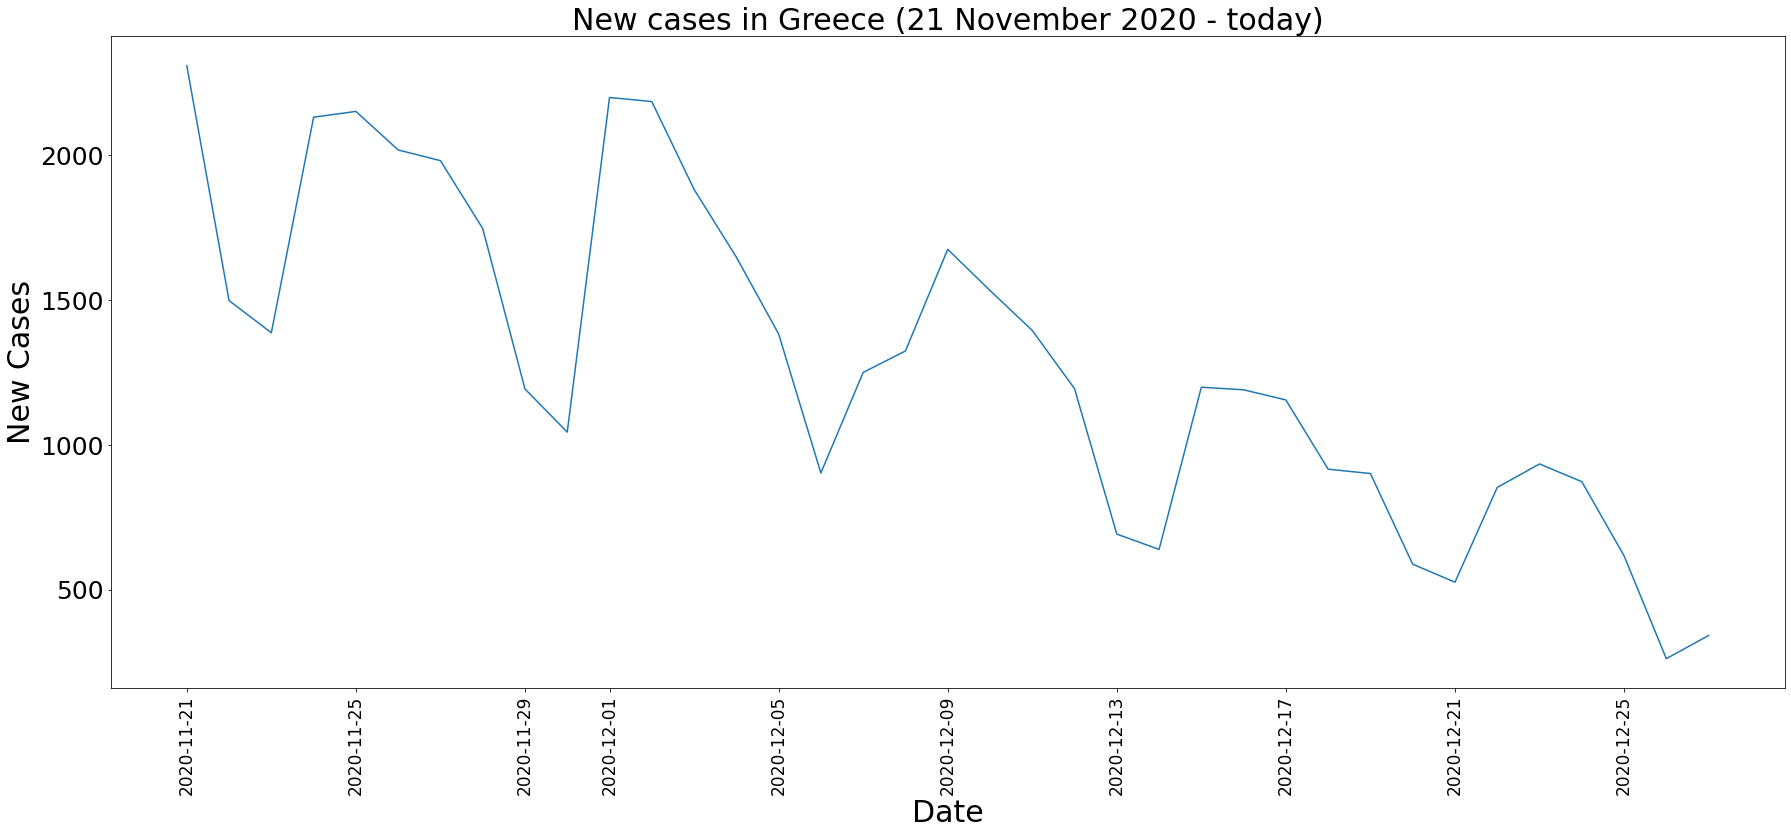

In [411]:
plt.figure(figsize=(30,12))
plt.title('New cases in Greece (21 November 2020 - today)', fontsize=30)
plt.ylabel('New Cases', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=25)
plt.plot(df_copy['Date_reported'], df_copy['New_cases'])

# New deaths graph<a name="new_deaths_graph"></a>

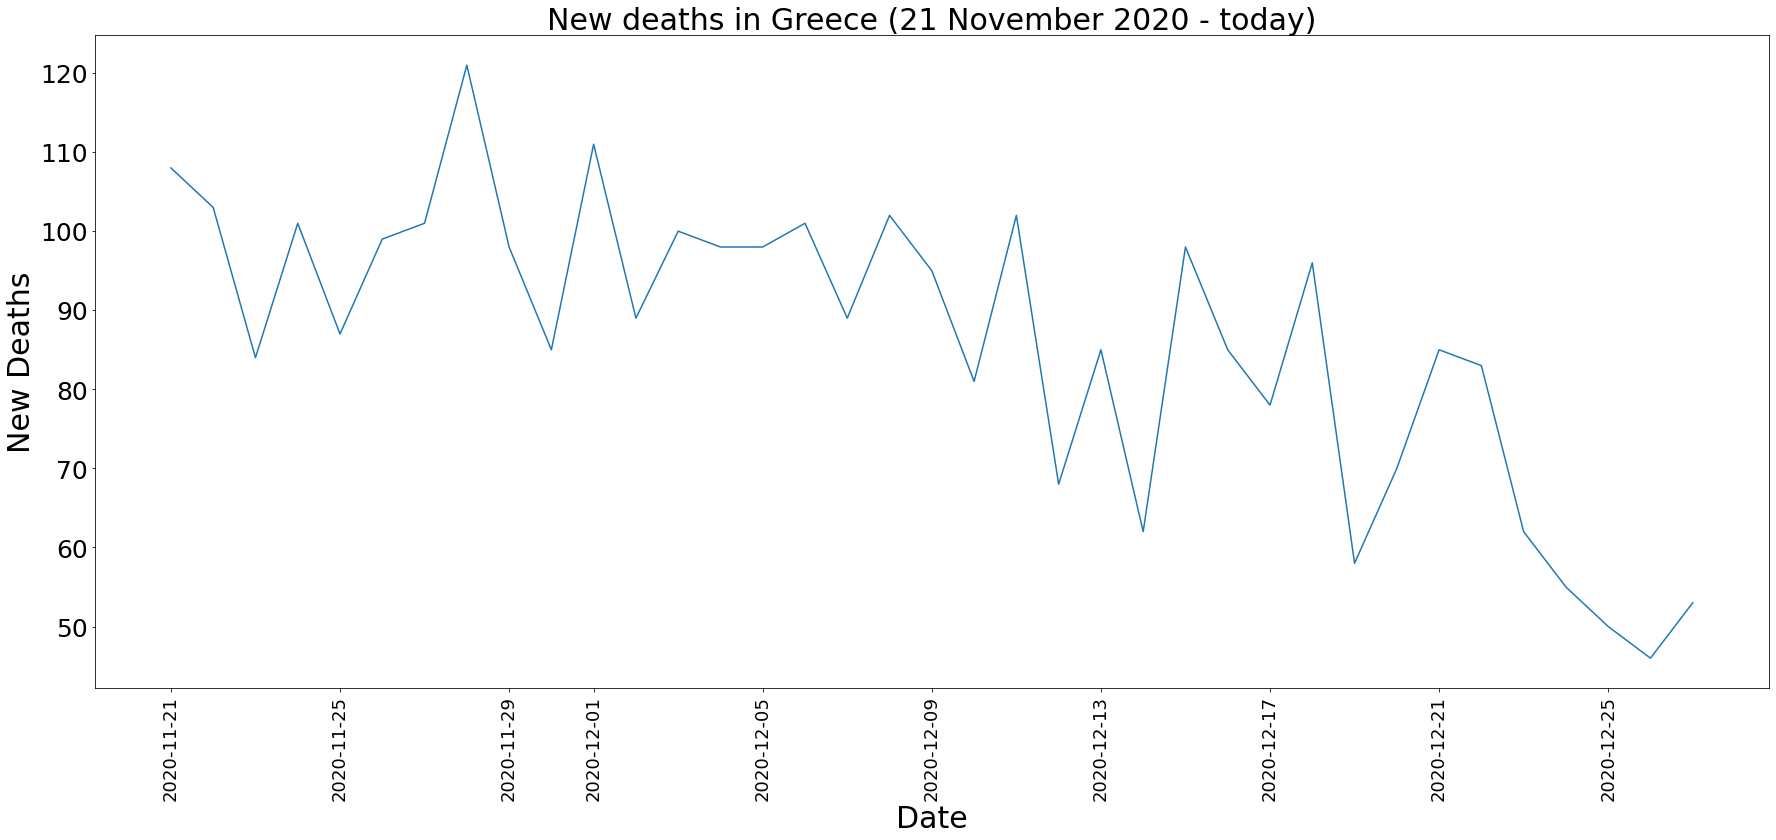

In [412]:
plt.figure(figsize=(30,12))
plt.title('New deaths in Greece (21 November 2020 - today)',fontsize=30)
plt.ylabel('New Deaths',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.xticks(rotation=90)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=18)
plt.plot(df_copy['Date_reported'], df_copy['New_deaths'])

# Total cases graph<a name="total_cases_graph"></a>

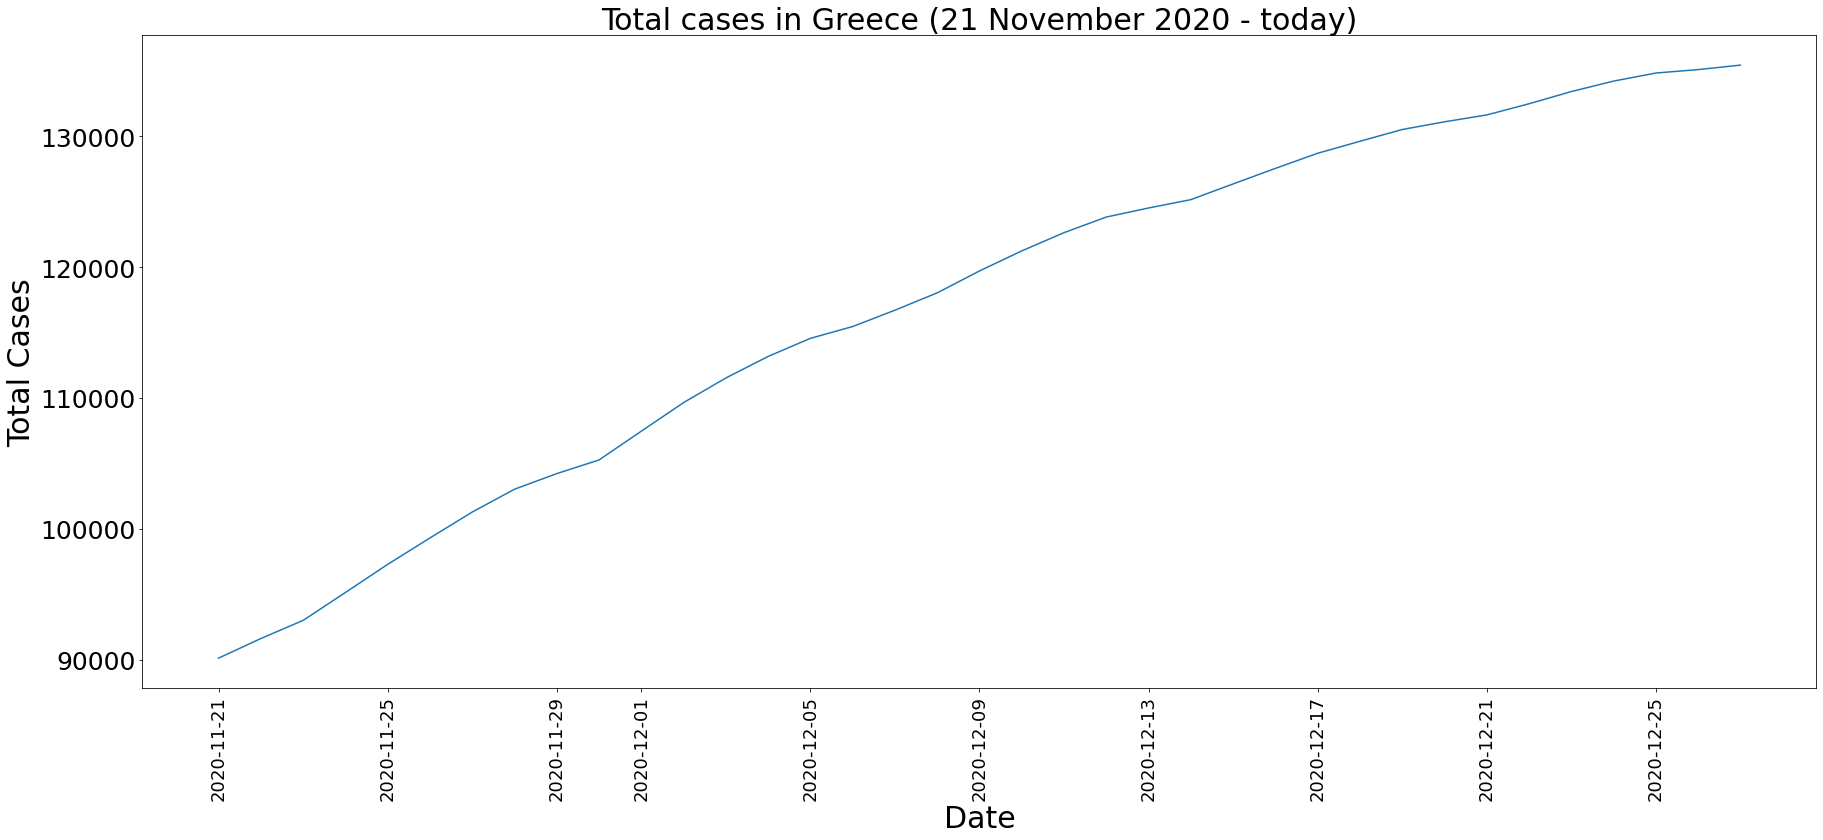

In [413]:
plt.figure(figsize=(30,12))
plt.title('Total cases in Greece (21 November 2020 - today)',fontsize=30)
plt.ylabel('Total Cases',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=25)
plt.plot(df_copy['Date_reported'], df_copy['Total_cases'])

# Total deaths graph<a name="total_deaths_graph"></a>

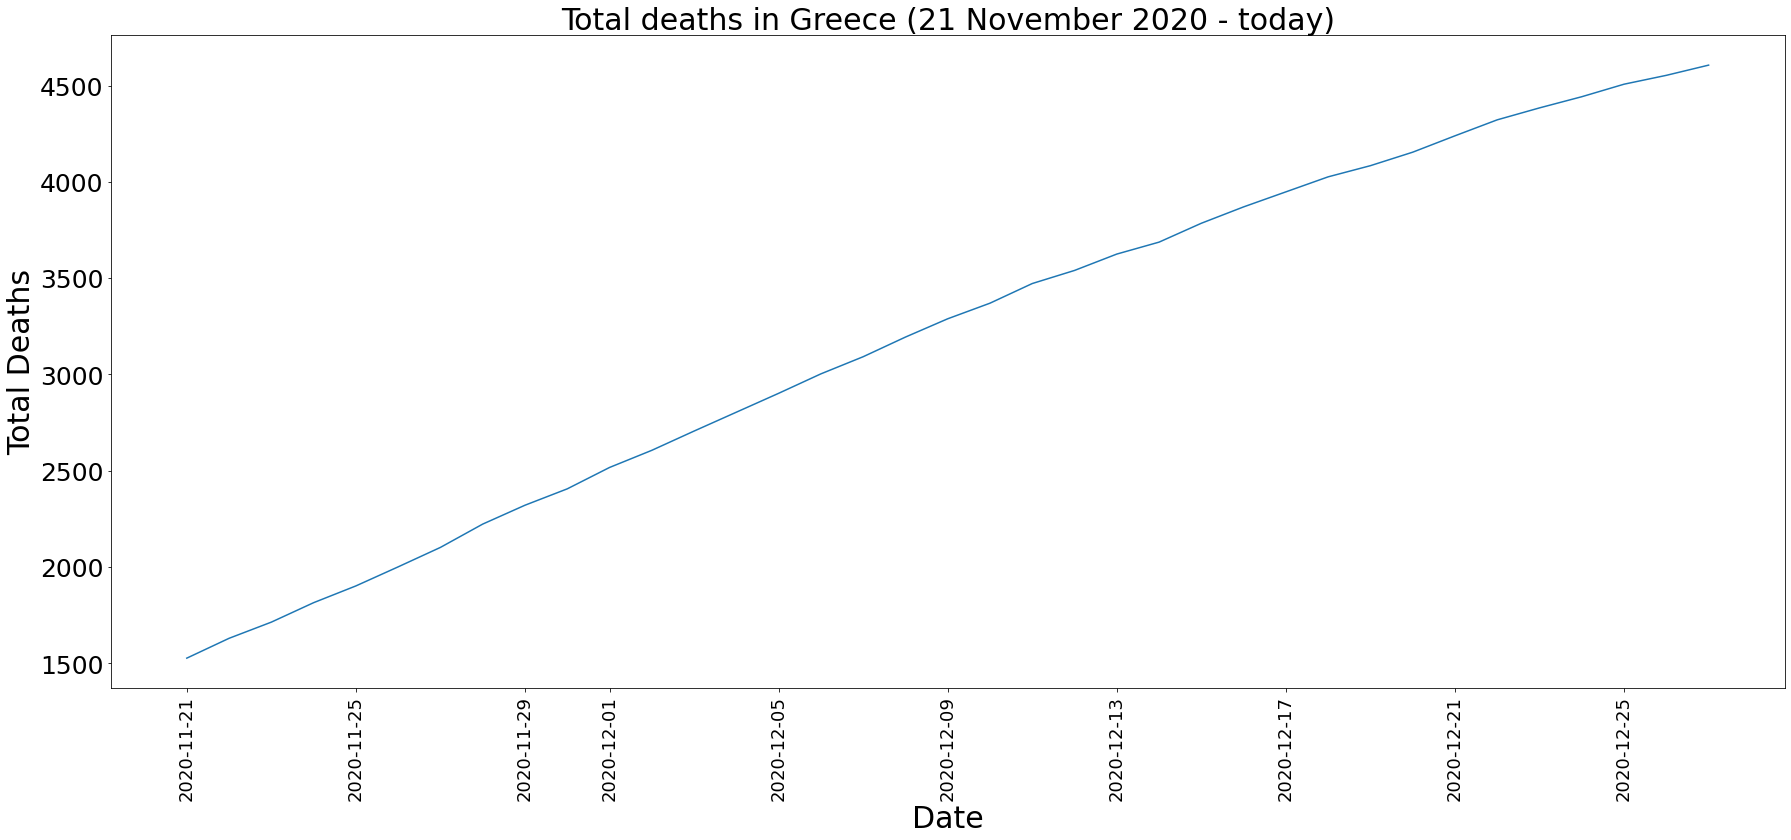

In [414]:
plt.figure(figsize=(30,12))
plt.title('Total deaths in Greece (21 November 2020 - today)',fontsize=30)
plt.ylabel('Total Deaths',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=25)
plt.plot(df_copy['Date_reported'], df_copy['Total_deaths'])

# Ιntubated Graph

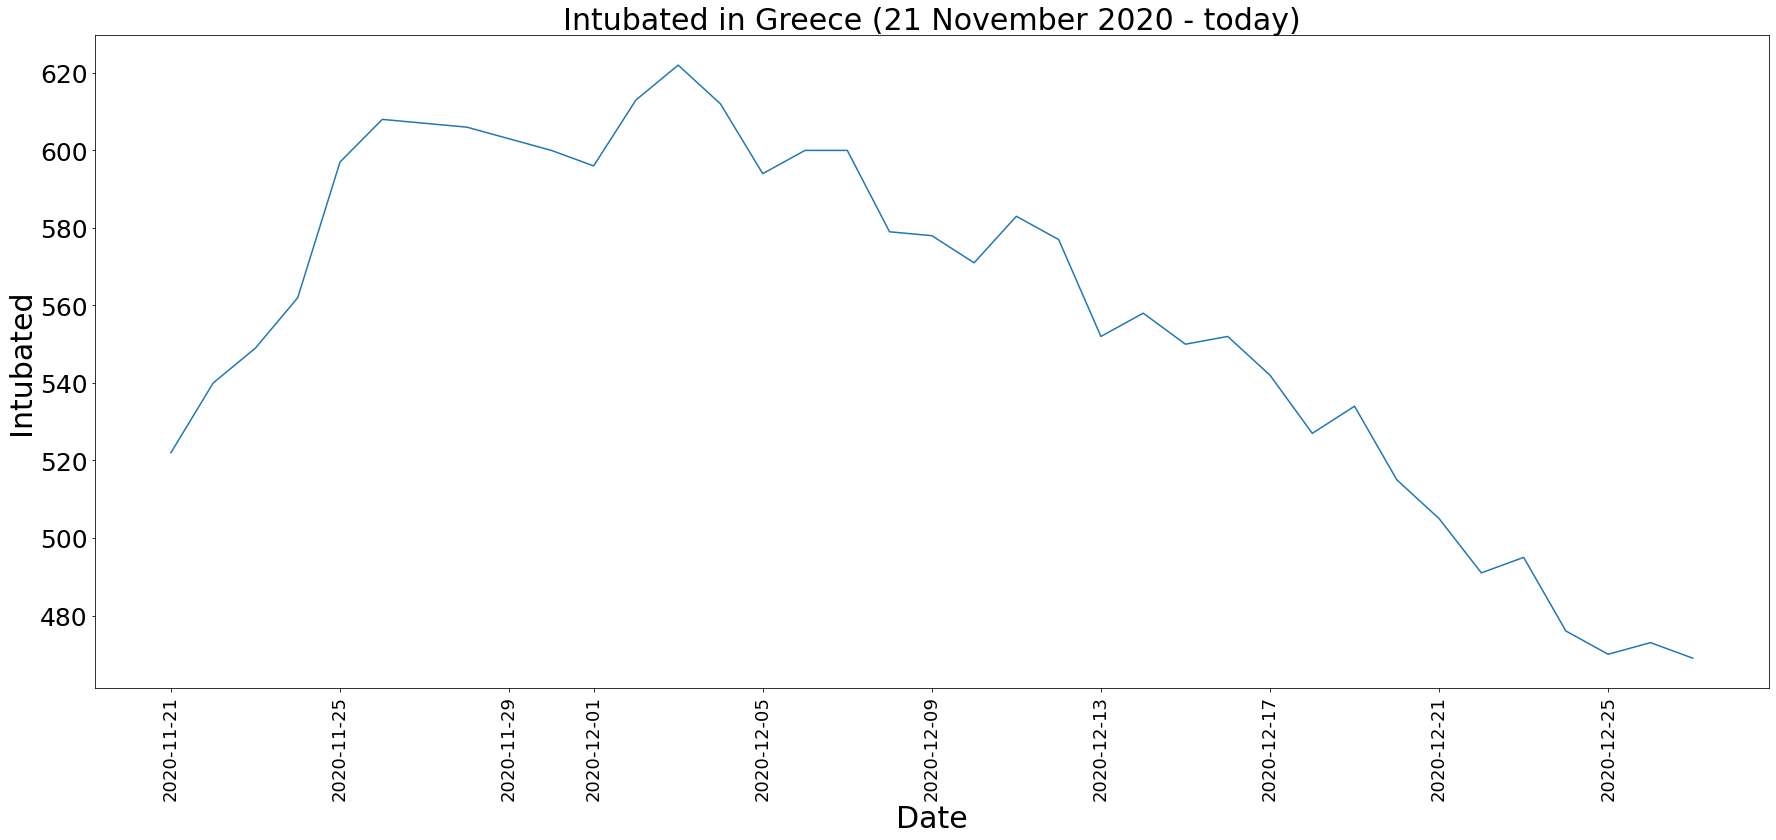

In [415]:
plt.figure(figsize=(30,12))
plt.title('Intubated in Greece (21 November 2020 - today)',fontsize=30)
plt.ylabel('Intubated',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=25)
plt.plot(df_copy['Date_reported'], df_copy['intubated'])

## Using Prophet to predict covid-19 behavior to 1 week from today

In [416]:
from fbprophet import Prophet

In [417]:
new_cases=df_copy.groupby('Date_reported').sum()['New_cases'].reset_index()
new_deaths=df_copy.groupby('Date_reported').sum()['New_deaths'].reset_index()
intubated=df_copy.groupby('Date_reported').sum()['intubated'].reset_index()

## Prediction of new deaths <a name="prediction_new_deaths"></a>

In [418]:
new_deaths.tail()

,Date_reported,New_deaths
32,2020-12-23,62
33,2020-12-24,55
34,2020-12-25,50
35,2020-12-26,46
36,2020-12-27,53


In [419]:
new_deaths.columns=['ds','y']

In [420]:
m=Prophet(interval_width=0.9)
m.fit(new_deaths)
future_new_deaths=m.make_future_dataframe(periods=7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [421]:
forecast_new_deaths=m.predict(future_new_deaths)
forecast_new_deaths.yhat = forecast_new_deaths.yhat.astype(int)
forecast_new_deaths.yhat_lower = forecast_new_deaths.yhat_lower.astype(int)
forecast_new_deaths.yhat_upper = forecast_new_deaths.yhat_upper.astype(int)
forecast_new_deaths[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
37,2020-12-28,53,36,71
38,2020-12-29,71,53,88
39,2020-12-30,56,39,71
40,2020-12-31,55,37,72
41,2021-01-01,61,43,78
42,2021-01-02,51,34,68
43,2021-01-03,52,35,71


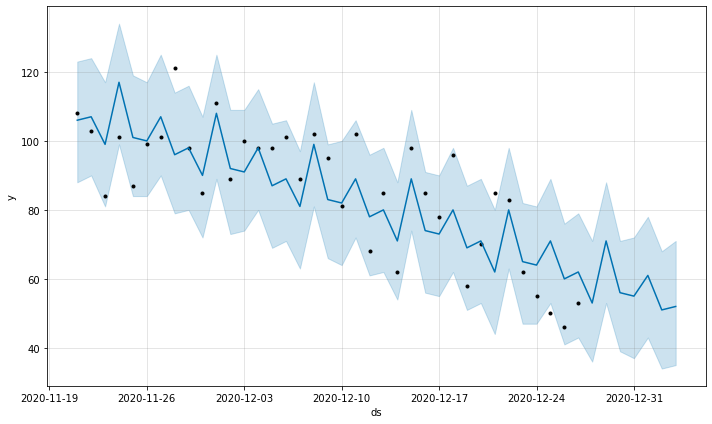

In [422]:
forecast_new_deaths_plot=m.plot(forecast_new_deaths)

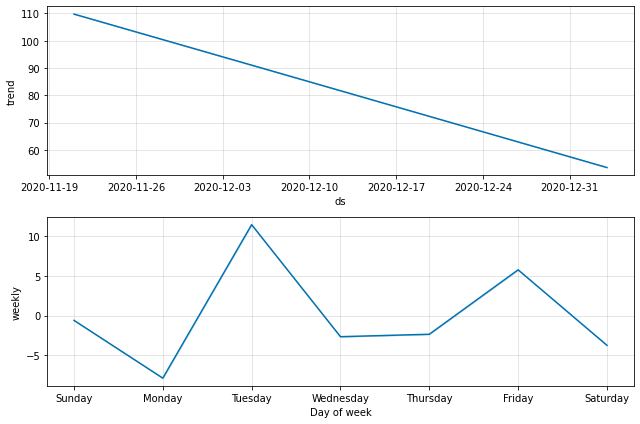

In [423]:
forecast_new_deaths_plot=m.plot_components(forecast_new_deaths)

In [424]:
forecast_new_deaths[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(r'C:\Users\Nick\Documents\git\reports\predicted_new_deaths_csv' + '\\' + predicted_new_deaths_file_name, index = False)

## Prediction of new cases<a name="prediction_new_cases"></a>

In [425]:
new_cases.tail()

,Date_reported,New_cases
32,2020-12-23,934
33,2020-12-24,873
34,2020-12-25,617
35,2020-12-26,262
36,2020-12-27,342


In [426]:
new_cases.columns=['ds','y']

In [427]:
m=Prophet(interval_width=0.99)
m.fit(new_cases)
future_new_cases=m.make_future_dataframe(periods=7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [428]:
forecast_new_cases=m.predict(future_new_cases)
forecast_new_cases['yhat_lower'] = forecast_new_cases['yhat_lower'].abs()
forecast_new_cases.yhat = forecast_new_cases.yhat.astype(int)
forecast_new_cases.yhat_lower = forecast_new_cases.yhat_lower.astype(int)
forecast_new_cases.yhat_upper = forecast_new_cases.yhat_upper.astype(int)
forecast_new_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
37,2020-12-28,52,306,419
38,2020-12-29,624,254,1052
39,2020-12-30,710,347,1123
40,2020-12-31,575,192,958
41,2021-01-01,394,19,766
42,2021-01-02,230,148,615
43,2021-01-03,-199,603,175


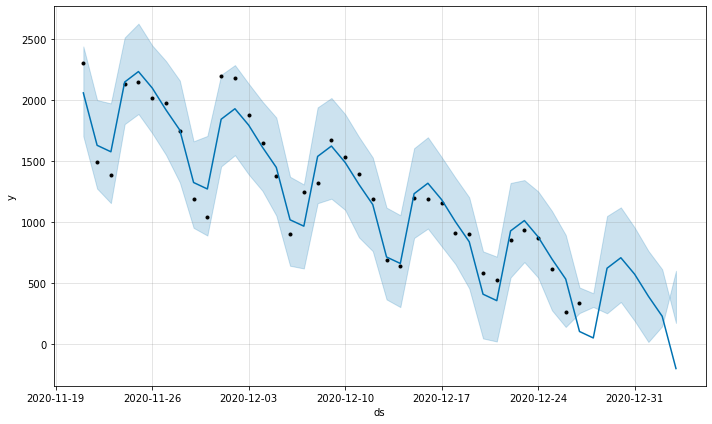

In [429]:
forecast_new_cases_plot=m.plot(forecast_new_cases)

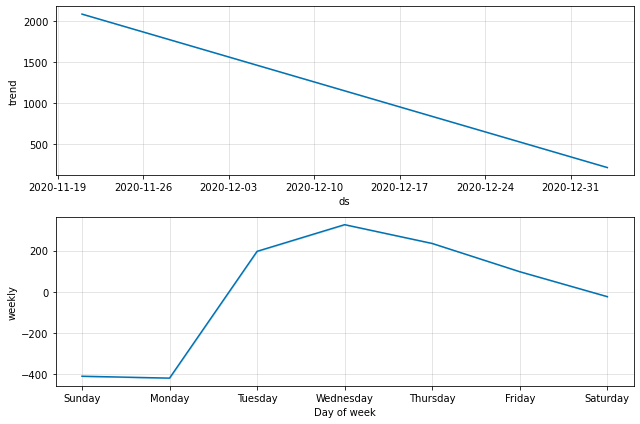

In [430]:
forecast_new_cases_plot=m.plot_components(forecast_new_cases)

In [431]:
forecast_new_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(r'C:\Users\Nick\Documents\git\reports\predicted_new_cases_csv' + '\\' + predicted_new_cases_file_name, index = False)

# Predictions of intubated

In [432]:
intubated.tail()

,Date_reported,intubated
32,2020-12-23,495
33,2020-12-24,476
34,2020-12-25,470
35,2020-12-26,473
36,2020-12-27,469


In [433]:
intubated.columns=['ds','y']

In [434]:
m=Prophet(interval_width=0.959)
m.fit(intubated)
future_intubated=m.make_future_dataframe(periods=7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [435]:
forecast_new_intubated=m.predict(future_intubated)
forecast_new_intubated.yhat = forecast_intubated.yhat.astype(int)
forecast_new_intubated.yhat_lower = forecast_intubated.yhat_lower.astype(int)
forecast_new_intubated.yhat_upper = forecast_intubated.yhat_upper.astype(int)
forecast_new_intubated[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
37,2020-12-28,452,437,465
38,2020-12-29,438,425,452
39,2020-12-30,444,428,459
40,2020-12-31,434,418,450
41,2021-01-01,425,405,444
42,2021-01-02,417,394,439
43,2021-01-03,407,381,433


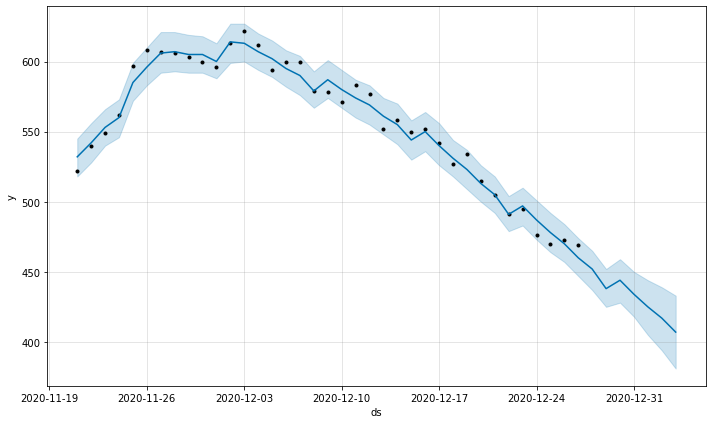

In [436]:
forecast_new_intubated_plot=m.plot(forecast_intubated)

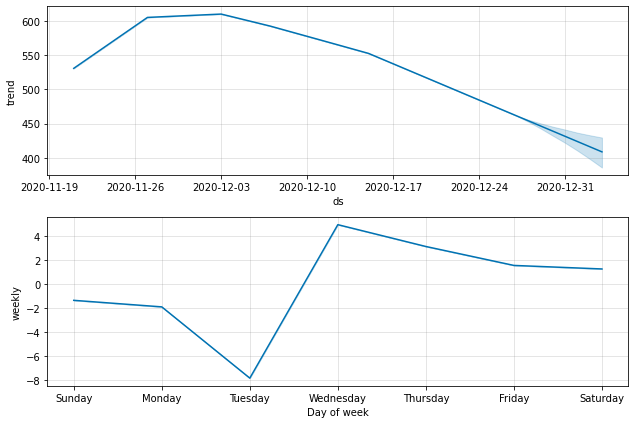

In [437]:
forecast_new_intubated_plot=m.plot_components(forecast_intubated)

In [438]:
forecast_new_intubated[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(r'C:\Users\Nick\Documents\git\reports\predicted_new_intubated_csv' + '\\' + predicted_new_intubated_file_name, index = False)